Iteration 10, Loss: 35.38099670410156
Iteration 20, Loss: 29.7314510345459
Iteration 30, Loss: 17.466808319091797
Iteration 40, Loss: 10.17742919921875
Iteration 50, Loss: -4.543682098388672
Iteration 60, Loss: -4.761051177978516
Iteration 70, Loss: -6.217823028564453
Iteration 80, Loss: -9.787750244140625
Iteration 90, Loss: -3.3853416442871094
Iteration 100, Loss: -6.929424285888672


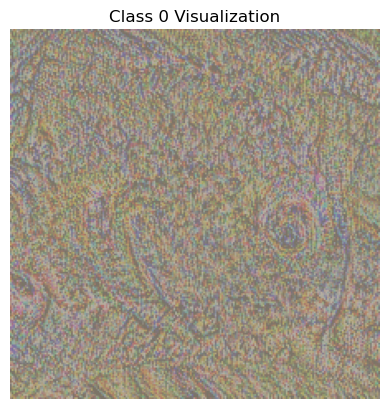

In [4]:
import torch
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
from torchvision.transforms.functional import rotate

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



Iteration 30, Loss: 12.439233779907227


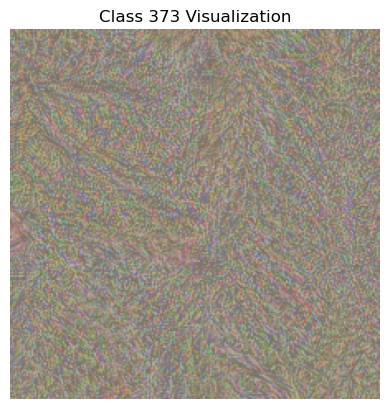

Iteration 60, Loss: -8.443901062011719
Iteration 90, Loss: -22.330303192138672


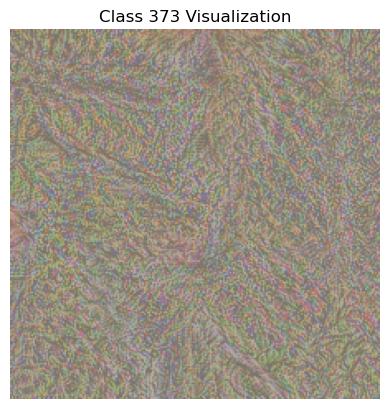

Iteration 120, Loss: -15.860418319702148
Iteration 150, Loss: -28.72722816467285


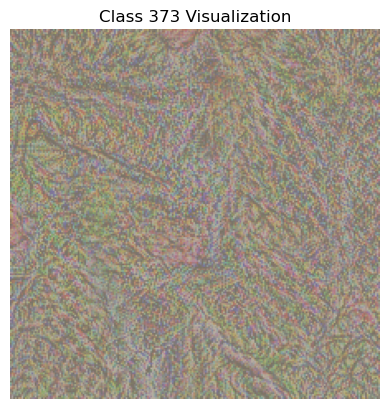

Iteration 180, Loss: -31.271774291992188


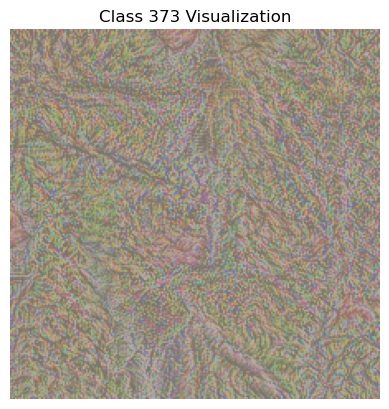

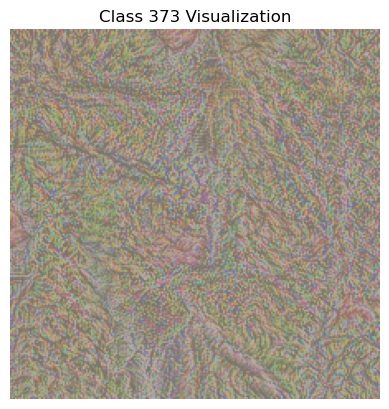

In [21]:

# Choose the target output unit (e.g., class index 130)
target_class = 373

# Initialize the input image with random noise mean 0.5 and std 0.05
input_img = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)

# Define the optimizer
optimizer = optim.Adam([input_img], lr=0.05)

# Define normalization parameters
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

# define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# add rotation to transform
rotation = 5
transform = transforms.Compose([
    transforms.RandomRotation(rotation),
    transforms.Normalize(mean=mean, std=std)
])

# Define rotation and total variation loss weights
rotation_strength = 5.0  # Maximum rotation angle in degrees
tv_weight = 0.0005
l1_weight = 0.005

def total_variation_loss(x):
    """Compute the total variation loss."""
    loss = torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])) + \
           torch.sum(torch.abs(x[:, :-1, :, :] - x[:, 1:, :, :]))
    return tv_weight * loss

for i in range(200):
    optimizer.zero_grad()
    
    # Forward pass
    output = model(transform(input_img))
    
    # Loss: negative activation + L2 penalty + total variation loss
    loss = -output[0, target_class] + l1_weight * torch.norm(input_img, 6) + total_variation_loss(input_img)
    # Backward pass
    loss.backward()
    
    # Update image
    optimizer.step()
    
    # Clamp image values to ensure they stay within a valid range
    input_img.data = torch.clamp(input_img.data, 0, 1)
    
    if (i + 1) % 30 == 0:
        print(f"Iteration {i + 1}, Loss: {loss.item()}")
    # showe every 100 iterations img
    if (i + 1) % 50 == 0:
        output_img = input_img.detach().squeeze().permute(1, 2, 0).cpu().numpy()
        output_img = output_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        output_img = np.clip(output_img, 0, 1)
        plt.imshow(output_img)
        plt.title(f'Class {target_class} Visualization')
        plt.axis('off')
        plt.show()

# Post-process and visualize the image
output_img = input_img.detach().squeeze().permute(1, 2, 0).cpu().numpy()
output_img = output_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
output_img = np.clip(output_img, 0, 1)

plt.imshow(output_img)
plt.title(f'Class {target_class} Visualization')
plt.axis('off')
plt.show()

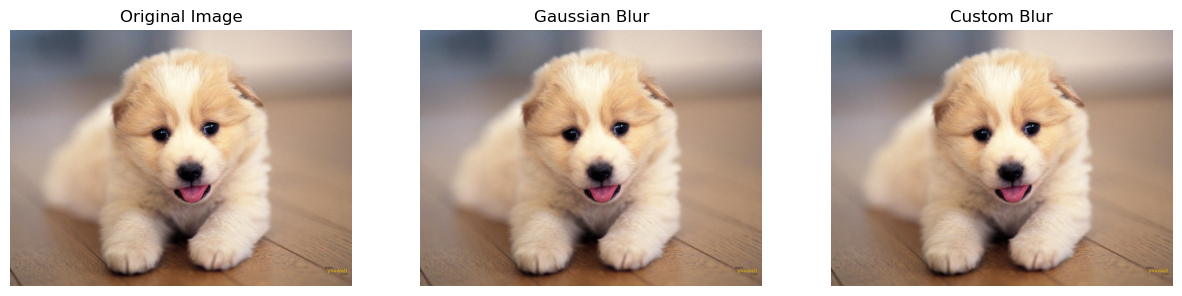

In [42]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Load an example image
image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallpaperaccess.com%2Ffull%2F327688.jpg&f=1&nofb=1&ipt=7f9819d2ce0b6b24981cb1bf7a82ff7c11e0c0111382af8f213d2bdb60502988&ipo=images"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert('RGB')
transform = transforms.ToTensor()
input_img = transform(image).unsqueeze(0)

# Apply Gaussian blur
gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(10))
blurred_img_gaussian = gaussian_blur(input_img)

# Define custom blur function
def pytorch_blur(x, w=3):
    depth = x.shape[1]  # In PyTorch, the channel dimension is the second dimension (N, C, H, W)
    k = np.zeros([depth, 1, w, w])
    
    for ch in range(depth):
        k_ch = k[ch, 0, :, :]
        k_ch[:, :] = 0.5
        k_ch[1:-1, 1:-1] = 1.0
    
    k = torch.tensor(k, dtype=torch.float32).to(x.device)
    
    def conv_k(t):
        return torch.nn.functional.conv2d(t, k, padding=w//2, groups=depth)
    
    return conv_k(x) / conv_k(torch.ones_like(x))

blurred_img_custom = pytorch_blur(input_img)

# Convert to numpy for visualization
def tensor_to_image(tensor):
    image = tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)
    return image

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(tensor_to_image(input_img))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tensor_to_image(blurred_img_gaussian))
plt.title("Gaussian Blur")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tensor_to_image(blurred_img_custom))
plt.title("Custom Blur")
plt.axis('off')

plt.show()


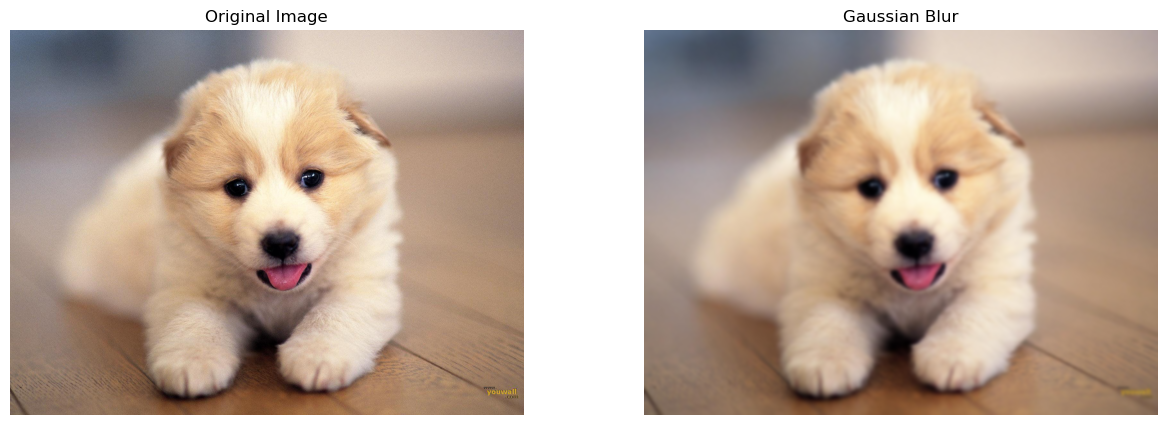

In [40]:
# import blurring transforms
from torchvision.transforms import GaussianBlur

# Apply Gaussian blur
gaussian_blur = GaussianBlur(kernel_size=33, sigma=(1,5))
blurred_img_gaussian = gaussian_blur(input_img)

# Convert to numpy for visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(input_img))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(blurred_img_gaussian))
plt.title("Gaussian Blur")
plt.axis('off')

plt.show()

Iteration 50/3000, Loss: 7.575123310089111
Iteration 100/3000, Loss: 5.245004653930664
Iteration 150/3000, Loss: 0.839195728302002
Iteration 200/3000, Loss: 1.8453187942504883
Iteration 250/3000, Loss: 2.1157004833221436
Iteration 300/3000, Loss: -7.330749034881592
Iteration 350/3000, Loss: 1.6941380500793457
Iteration 400/3000, Loss: -10.327203750610352
Iteration 450/3000, Loss: -5.08633279800415
Iteration 500/3000, Loss: -2.2365660667419434
Iteration 550/3000, Loss: -14.685846328735352
Iteration 600/3000, Loss: -15.422186851501465
Iteration 650/3000, Loss: -14.159370422363281
Iteration 700/3000, Loss: -8.701749801635742
Iteration 750/3000, Loss: -27.321237564086914
Iteration 800/3000, Loss: -15.823648452758789
Iteration 850/3000, Loss: -5.772354602813721
Iteration 900/3000, Loss: -0.29448413848876953
Iteration 950/3000, Loss: -12.8605318069458
Iteration 1000/3000, Loss: -19.792537689208984
Iteration 1050/3000, Loss: -13.164739608764648
Iteration 1100/3000, Loss: -17.196334838867188
I

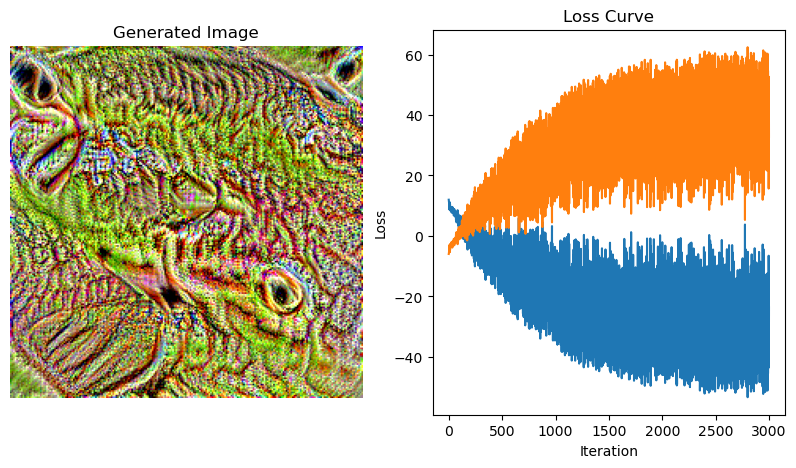

In [58]:
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to load image from URL
def load_image_from_url(url, transform=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    if transform:
        image = transform(image).unsqueeze(0)
    return image.to(device)

# Define the transformation
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #paddding
    transforms.Pad(padding=10, fill=0),
    # add salt and pepper noise
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 0.3), value=0),
    transforms.RandomRotation(degrees=5),
    # transforms.GaussianBlur(kernel_size=9, sigma=10)
    # rabndom scaling
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    # crop the padding
    transforms.CenterCrop(224),
])

# URL of the image to be used
image_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwallpaperaccess.com%2Ffull%2F327688.jpg&f=1&nofb=1&ipt=7f9819d2ce0b6b24981cb1bf7a82ff7c11e0c0111382af8f213d2bdb60502988&ipo=images"
# target_image = load_image_from_url(image_url, transform)

# Initialize a random noise image
input_img = torch.randn((1, 3, 224, 224), requires_grad=True, device=device)

# Define the optimizer
optimizer = optim.Adam([input_img], lr=0.05)

# Define the weights for the losses
l2_weight = 0
tv_weight = 0.001
l1_weight = 0.00005

# Total Variation Loss function
def total_variation_loss(x):
    tv_h = torch.mean(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return tv_weight * (tv_h + tv_w)

# Collect the loss
losses = []
class_scores = []

# Perform gradient descent to maximize the activity of the output unit of class 0
num_iterations = 3000

for i in range(num_iterations):

    optimizer.zero_grad()
    
    # Forward pass
    output = model(transform(input_img))
    class_score = output[0, 0]  # Maximize the score of the class 0 output unit
    class_scores.append(class_score.item())
    
    # Loss: negative of the class score + L2 penalty + TV loss + L1 loss
    loss = -class_score + l2_weight * torch.norm(input_img) + total_variation_loss(input_img) + l1_weight * torch.norm(input_img, 1)
    losses.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the image
    optimizer.step()
    
    # Clamp image values to ensure they stay within a valid range
    # input_img.data = torch.clamp(input_img.data, 0, 1)
    
    if (i + 1) % 50 == 0:
        print(f"Iteration {i + 1}/{num_iterations}, Loss: {loss.item()}")

# Post-process and visualize the reconstructed image
output_img = input_img.detach().squeeze().permute(1, 2, 0).cpu().numpy()
output_img = output_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
output_img = np.clip(output_img, 0, 1)

# Display the reconstructed image and the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output_img)
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 2, 2)

# Plot the loss curve and the class score curve
plt.plot(losses)
plt.plot(class_scores)
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
